# Review of Linear Unsupervised Learning

In this notebook, we will briefly review some of the key concepts of linear unsupervised learning, including Principal Component Analysis (PCA) and the effects of regularizations on linear decompositions, such as SparsePCA and Non-negative Matrix Factorization (NMF). We will use a set of airfoil geometries to demonstrate these effects visually.

In [1]:
from matplotlib import pyplot as plt
import numpy as np

First, let's load some airfoil geometry coordinates, take a look at the shape of the data matrix, and pick a random one to visualize.

The shape of the airfoil dataset is (1528, 192, 2)


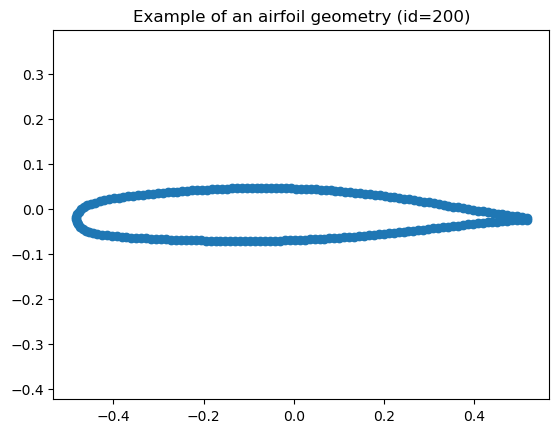

In [2]:
#| code-fold: false
data_fname = 'airfoil_interp.npy'
data_fname = 'airfoil_interp_uniform.npy'
X_airfoils = np.load(data_fname)

# Reshape the matrix so that it is N by D
# where D is the X and Y coordinates concantinated together
make_matrix = lambda X: np.reshape(X, (X.shape[0], -1))
make_airfoils = lambda X: X.reshape((X.shape[0], -1, 2))
make_airfoil = lambda X: X.reshape((-1, 2))

# Centering the airfoils
X_airfoils[:,:,0] -= X_airfoils[:,:,0].mean()
X_airfoils[:,:,1] -= X_airfoils[:,:,1].mean()

print(f"The shape of the airfoil dataset is {X_airfoils.shape}")

# Split training and test data
test_split = 0.8
N = X_airfoils.shape[0]
split = int(N*test_split)
X_train = X_airfoils[:split]

airfoil_id = 200
plt.figure()
plt.scatter(X_airfoils[airfoil_id,:,0],
            X_airfoils[airfoil_id,:,1])
plt.axis('equal')
plt.title(f"Example of an airfoil geometry (id={airfoil_id})")
plt.show()

Great, as we can see there are 1528 airfoils, expressed as 192 surface coordinates each with and x and y value. We can turn this into a matrix compatible with a linear decomposition by flattening the last two dimensions, so that each airfoil is a row vector of length 384.

Matrix Shape: (1222, 384)
Airfoils Data Shape: (1222, 192, 2)


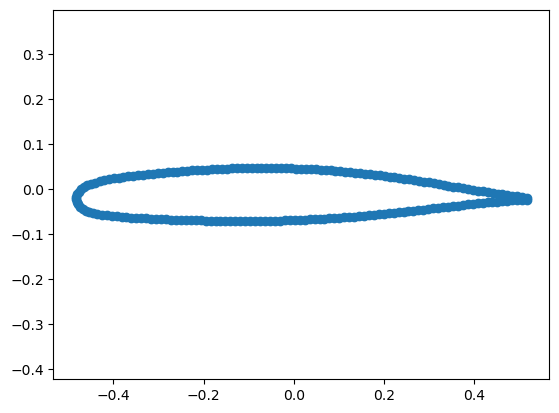

In [3]:
#| code-fold: false
# Reshape the matrix
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_train = make_matrix(X_train)
print("Matrix Shape:",X_train.shape)
data = X_train

# Transform back to original shape for plotting
# That is, make it back to N by 192 by 2
airfoils = make_airfoils(X_train)
print("Airfoils Data Shape:",airfoils.shape)
plt.figure()
plt.scatter(airfoils[airfoil_id,:,0],
            airfoils[airfoil_id,:,1])
plt.axis('equal')
plt.show()

## Dimension Reduction
Now let's demonstrate how to use various dimension reduction algorithms on this example.

### Principal Component Analysis

In [4]:
from sklearn import decomposition

# Number of Components
n_components = 20
print("Number of Target Latent Components:",n_components)
estimator = decomposition.PCA(n_components=n_components)
estimator.fit(data)
components_ = estimator.components_


Number of Target Latent Components: 20


We see that we now possess a matrix (i.e., linear operator) that goes from the target 20 components/dimensions back to the original 382 dimensions.

In [5]:
#| code-fold: false
components_.shape

(20, 384)

We can visualize the importance of each component by plotting the explained variance:

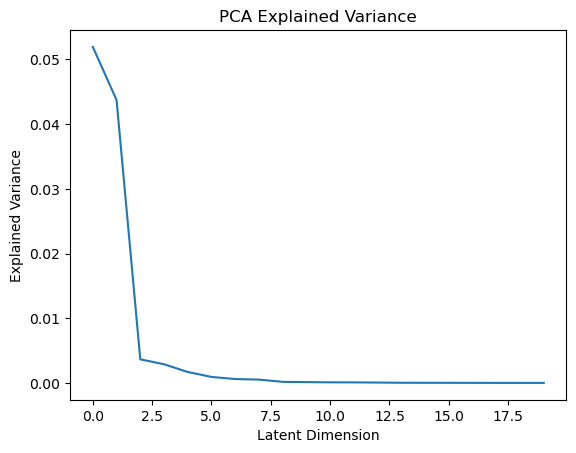

In [6]:
plt.figure()
plt.plot(estimator.explained_variance_)
plt.ylabel("Explained Variance")
plt.xlabel("Latent Dimension")
plt.title("PCA Explained Variance")
plt.show()

We can also visualize the cumulative explained variance to see how many components are needed to explain a certain amount of variance in the data. For example, we can plot a line at the number of dimensions we need to keep to explain 99% of the variance:

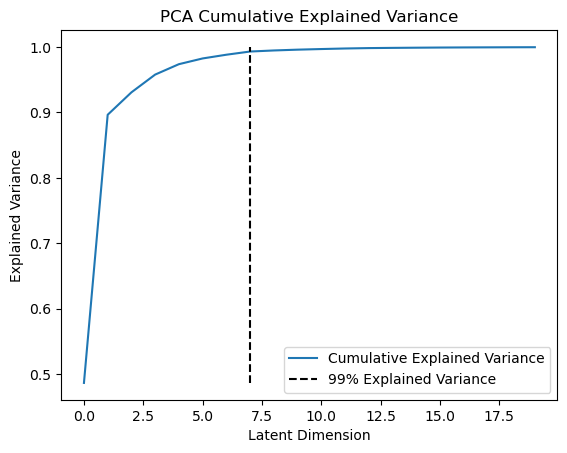

In [7]:
cumulative_explained_var_ratio = np.cumsum(estimator.explained_variance_ratio_)
number_of_vars_to_99 = np.argmax(cumulative_explained_var_ratio>.99)
plt.figure()
plt.plot(cumulative_explained_var_ratio,label="Cumulative Explained Variance")
plt.ylabel("Explained Variance")
plt.xlabel("Latent Dimension")
plt.vlines(number_of_vars_to_99,
           np.min(cumulative_explained_var_ratio),1.0,
           colors="k",linestyles='dashed',
          label = "99% Explained Variance")
plt.legend()
plt.title("PCA Cumulative Explained Variance")
plt.show()

Or plot the explained variance ratio as a function of the number of components, which tells us how much each additional component contributes to the total explained variance:

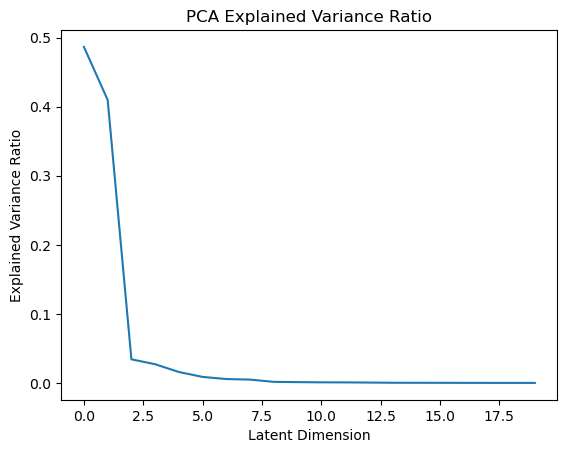

In [8]:
plt.figure()
plt.plot(estimator.explained_variance_ratio_)
plt.ylabel("Explained Variance Ratio")
plt.xlabel("Latent Dimension")
plt.title("PCA Explained Variance Ratio")
plt.show()

We can see that this approximately follows the singular values of the data matrix:

Singular Values: [7.96347431 7.30793278 2.11271967 1.880563   1.43978062 1.06857152
 0.86184436 0.79754077 0.46006406 0.40013427 0.3503857  0.33218949
 0.28107742 0.20708862 0.19063632 0.17582911 0.14392864 0.1288838
 0.12505431 0.10367465]


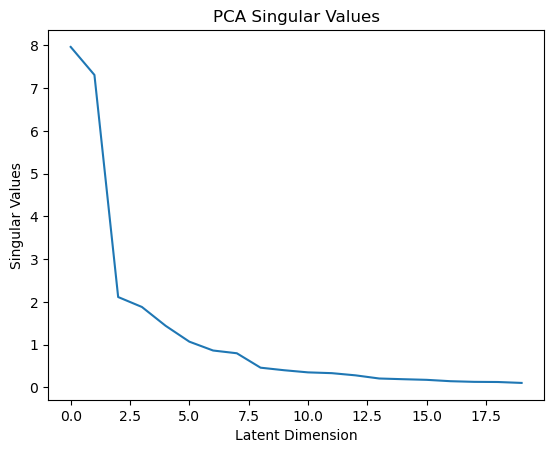

In [9]:
print(f"Singular Values: {estimator.singular_values_}")
plt.figure()
plt.plot(estimator.singular_values_)
plt.ylabel("Singular Values")
plt.xlabel("Latent Dimension")
plt.title("PCA Singular Values")
plt.show()

Moving beyond just the singular values, we can also now look at the projection of each airfoil into any of the latent dimensions. It is natural to explore the first two, since those explain the largest variance:

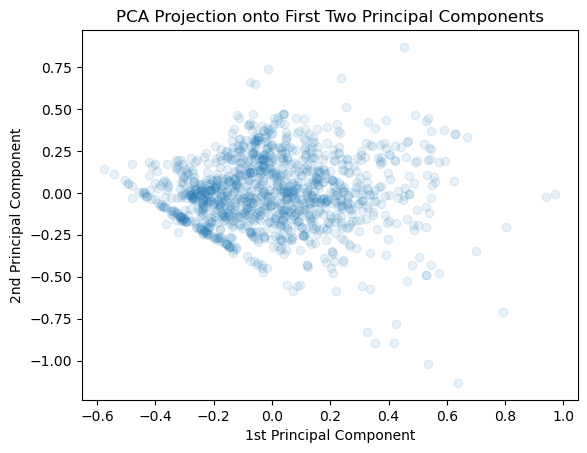

In [10]:
z = estimator.transform(data)
plt.figure()
plt.scatter(z[:,0],z[:,1],alpha=0.1)
plt.xlabel("1st Principal Component")
plt.ylabel("2nd Principal Component")   
plt.title("PCA Projection onto First Two Principal Components")
plt.show()  

We can also pull out the "latent code/coordinates/vector" for an individual airfoil:

In [11]:
#| code-fold: false
z[airfoil_id,:]

array([-1.62226700e-01, -1.63666809e-01,  3.59980104e-03,  8.17031623e-03,
       -1.28603395e-02,  3.63720992e-02,  1.00303147e-02, -4.40716928e-03,
       -1.25849625e-02, -1.65373143e-02, -6.22389194e-05, -1.07586551e-02,
        3.93209177e-03, -8.00351892e-03,  9.77030463e-03, -9.72268324e-04,
       -2.64698362e-03, -1.37657657e-03, -1.39477899e-03,  2.49486113e-03])

### How does the # Components affect the Airfoil Reconstruction?

We can see visually the effect of including an increasing number of components by looking at how this affects the reconstruction of a single airfoil:

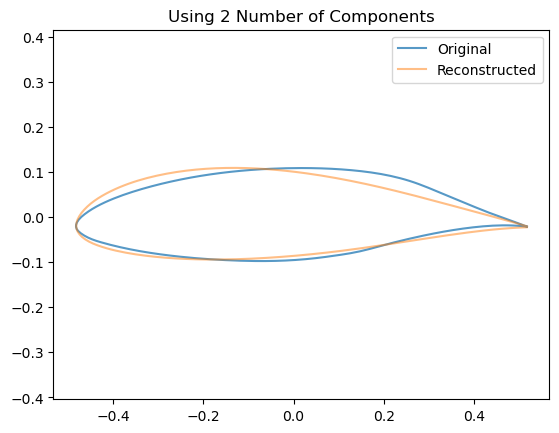

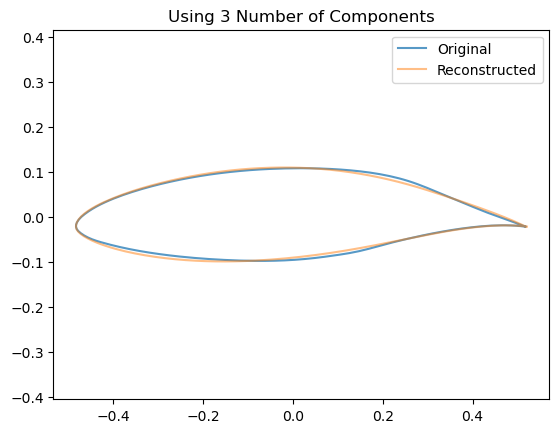

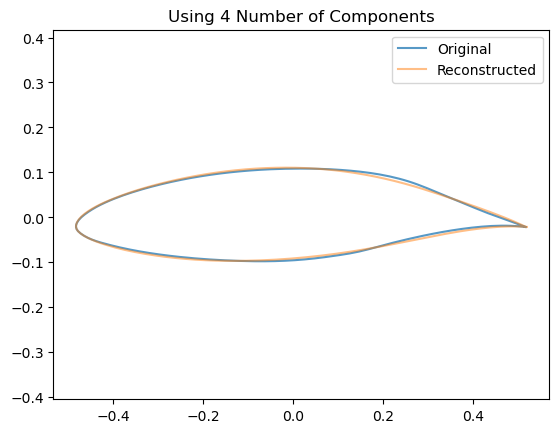

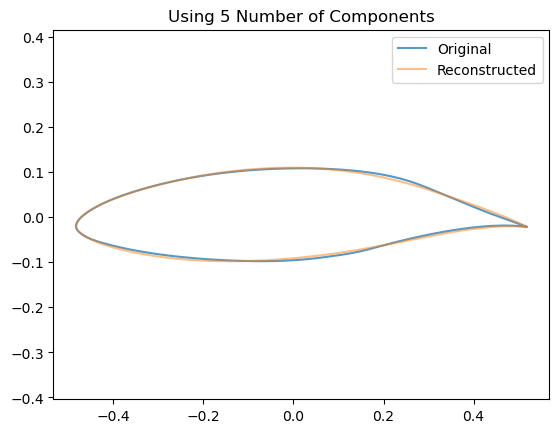

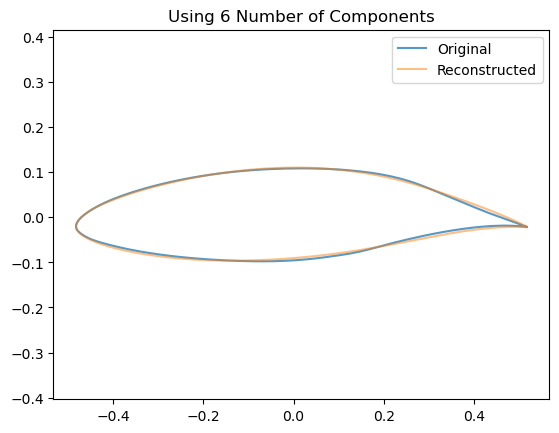

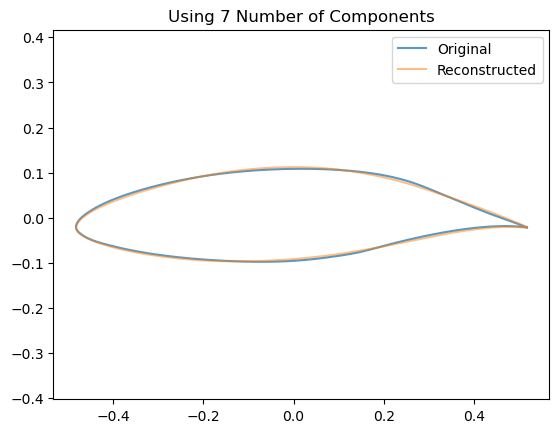

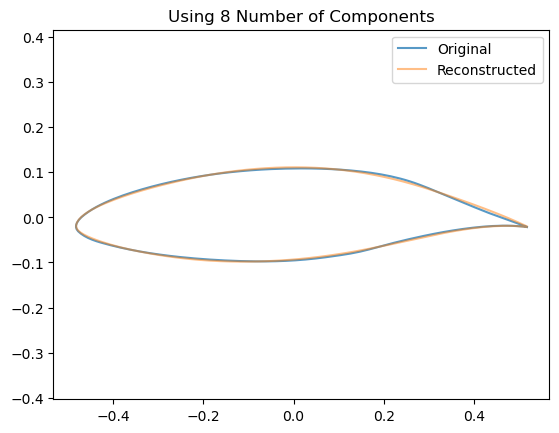

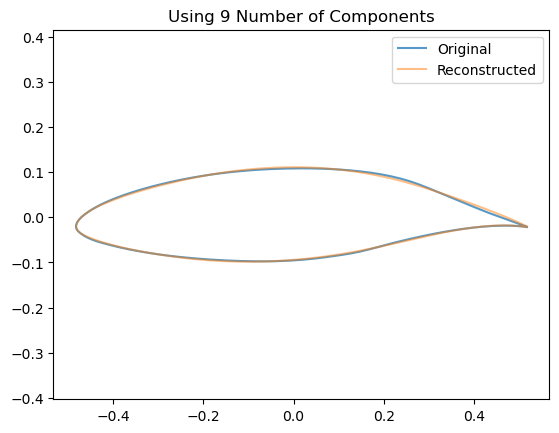

In [12]:
airfoil_id = 0
for n_components in range(2,10):
    estimator = decomposition.PCA(n_components=n_components, whiten=False)
    
    # Train the model
    estimator.fit(data)
    # Project down to the low dimensional space
    z     = np.dot(data - estimator.mean_, estimator.components_.T)
    # Re-Project back to the high dimensional space
    x_hat = np.dot(z[0], estimator.components_) + estimator.mean_

    # Now plot them
    airfoil_original = make_airfoil(data[0])
    airfoil_reconstructed = make_airfoil(x_hat)
    airfoil_mean = make_airfoil(estimator.mean_)
    plt.figure()
    plt.plot(airfoil_original[:,0],
             airfoil_original[:,1],
             alpha=0.75,
             label = 'Original')
    plt.plot(airfoil_reconstructed[:,0],
                airfoil_reconstructed[:,1],
                alpha=0.5,
                label='Reconstructed')

    plt.title(f"Using {n_components} Number of Components")
    plt.legend()
    plt.axis('equal')
    plt.show()

We can compare also how the airfoil differs from the mean:

In [13]:
n_components = 5
estimator = decomposition.PCA(n_components=n_components, whiten=False)

def plot_reconstruction(estimator,data_index=0):
    mean_airfoil = data.mean(axis=0)
    # Train the model
    estimator.fit(data)
    # Project down to the low dimensional space
    z     = np.dot(data - mean_airfoil, estimator.components_.T)
    # Re-Project back to the high dimensional space
    x_hat = np.dot(z[data_index], estimator.components_) + mean_airfoil

    # Now plot them
    airfoil_original = make_airfoil(data[data_index])
    airfoil_reconstructed = make_airfoil(x_hat)
    
    #airfoil_mean = make_airfoil(estimator.mean_)
    airfoil_mean = make_airfoil(mean_airfoil)
    plt.plot(airfoil_original[:,0],
             airfoil_original[:,1],
             alpha=0.75,
             label = 'Original')
    plt.plot(airfoil_reconstructed[:,0],
                airfoil_reconstructed[:,1],
                alpha=0.5,
                label='Reconstructed')
    plt.plot(airfoil_mean[:,0],
             airfoil_mean[:,1],
             alpha=0.5,
             c='g',
             label='Mean')
    plt.legend()
    plt.axis('equal')

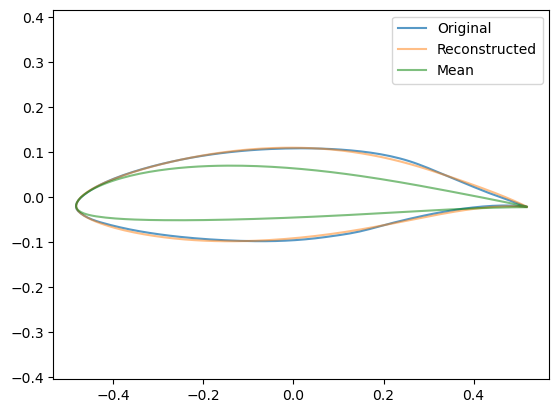

In [14]:
#| code-fold: false
n_components = 5
plot_reconstruction(decomposition.PCA(n_components=n_components, whiten=False))